In [1]:
from glob import glob
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL
from PIL import Image
import random
import shutil
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_curve
from sklearn import metrics
import time
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import Dataset, random_split, DataLoader

import torchvision.models as models
import torchvision.transforms as transforms

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')
data_dir = '/content/gdrive/MyDrive/DLS_FinalProject/'

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


# Seed

In [4]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed(1)

# Dataset and Dataloader

In [5]:
class ImageDataset(Dataset):
    def __init__(self, monet_dir, photo_dir, size=(256, 256)):
        super().__init__()
        self.monet_dir = monet_dir
        self.photo_dir = photo_dir
        self.monet_idx = dict()
        self.photo_idx = dict()

        self.transform = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                
            ])
       
        for i, fl in enumerate(os.listdir(self.monet_dir)):
            self.monet_idx[i] = fl
        for i, fl in enumerate(os.listdir(self.photo_dir)):
            self.photo_idx[i] = fl

    def __getitem__(self, idx):
        rand_idx = int(np.random.uniform(0, len(self.photo_idx.keys())))
        photo_path = os.path.join(self.photo_dir, self.photo_idx[rand_idx])
        monet_path = os.path.join(self.monet_dir, self.monet_idx[idx])
        photo_img = Image.open(photo_path)
        photo_img = self.transform(photo_img)
        monet_img = Image.open(monet_path)
        monet_img = self.transform(monet_img)
        return photo_img, monet_img

    def __len__(self):
        return min(len(self.monet_idx.keys()), len(self.photo_idx.keys()))

In [6]:
img_ds = ImageDataset(data_dir+'monet_jgp/', data_dir+'/photo_jpg/')

pin_memory: https://discuss.pytorch.org/t/when-to-set-pin-memory-to-true/19723/2

In [7]:
img_dl = DataLoader(img_ds, batch_size=1, pin_memory=True)

In [8]:
photo_img, monet_img = next(iter(img_dl))

https://www.geeksforgeeks.org/how-to-normalize-images-in-pytorch/

In [9]:
def de_normalize(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
        
    return img

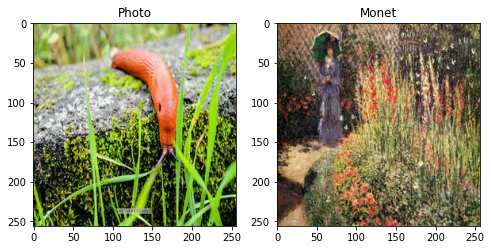

In [10]:
f = plt.figure(figsize=(8, 8))

f.add_subplot(1, 2, 1)
plt.title('Photo')
photo_img = de_normalize(photo_img)
plt.imshow(photo_img[0].permute(1, 2, 0))

f.add_subplot(1, 2, 2)
plt.title('Monet')
monet_img = de_normalize(monet_img)
plt.imshow(monet_img[0].permute(1, 2, 0))

# Model

https://www.kaggle.com/code/jesperdramsch/understanding-and-improving-cyclegans-tutorial/notebook

The downsample, as the name suggests, reduces the 2D dimensions, the width and height, of the image by the stride. The stride is the length of the step the filter takes. Since the stride is 2, the filter is applied to every other pixel, hence reducing the weight and height by 2.

Upsample does the opposite of downsample and increases the dimensions of the of the image. Conv2DTranspose does basically the opposite of a Conv2D layer.

Convolutional Layer

In [13]:
def Convlayer(in_ch, out_ch, kernel_size=3, stride=2, use_leaky=True, use_inst_norm=True, use_pad=True):

    # Convolution
    if use_pad:
        conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, 1, bias=True)
    else:
        conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, 0, bias=True)

    # Activation Function
    if use_leaky:
        actv = nn.LeakyReLU(negative_slope=0.2, inplace=True)
    else:
        actv = nn.GELU()

    # Normalization    
    if use_inst_norm:
        norm = nn.InstanceNorm2d(out_ch)
    else:
        norm = nn.BatchNorm2d(out_ch)

    return nn.Sequential(
        conv,
        norm,
        actv
    )

Transpose Convolutional Layer

In [14]:
def Upsample(in_ch, out_ch, use_dropout=True, dropout_ratio=0.5):

    return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 3, stride=2, padding=1, output_padding=1),  # Transposed Convolution
            nn.InstanceNorm2d(out_ch), # Normalization
            nn.Dropout(dropout_ratio), # Dropout Layer
            nn.GELU() # Activation Function
    )

Residual block

In [15]:
class Resblock(nn.Module):
    def __init__(self, in_features, dropout_ratio=0.5):
        super().__init__()
        layers = list()
        layers.append(nn.ReflectionPad2d(1)) # Padding
        layers.append(Convlayer(in_features, in_features, 3, 1, False, use_pad=False)) # Convolution Layer
        layers.append(nn.Dropout(dropout_ratio)) # Dropout 
        layers.append(nn.ReflectionPad2d(1)) # Padding
        layers.append(nn.Conv2d(in_features, in_features, 3, 1, padding=0, bias=True)) # Convolution
        layers.append(nn.InstanceNorm2d(in_features)) # Normalization
        self.res = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.res(x)

Generator

In [16]:
class Generator(nn.Module):
    def __init__(self, in_ch, out_ch, num_res_blocks=6):
        super().__init__()
        model = list()
        # Encoder
        model.append(nn.ReflectionPad2d(3))
        model.append(Convlayer(in_ch, 64, 7, 1, False, True, False))
        model.append(Convlayer(64, 128, 3, 2, False))
        model.append(Convlayer(128, 256, 3, 2, False))
        # Transformer
        for _ in range(num_res_blocks):
            model.append(Resblock(256))
        # Decoder
        model.append(Upsample(256, 128))
        model.append(Upsample(128, 64))
        model.append(nn.ReflectionPad2d(3))
        model.append(nn.Conv2d(64, out_ch, kernel_size=7, padding=0))
        model.append(nn.Tanh())

        self.gen = nn.Sequential(*model)

    def forward(self, x):
        return self.gen(x)

Discriminator

In [17]:
class Discriminator(nn.Module):
    def __init__(self, in_ch, num_layers=4):
        super().__init__()
        model = list()
        model.append(nn.Conv2d(in_ch, 64, 4, stride=2, padding=1))
        model.append(nn.LeakyReLU(0.2, inplace=True))
        for i in range(1, num_layers):
            in_chs = 64 * 2**(i-1)
            out_chs = in_chs * 2
            if i == num_layers -1:
                model.append(Convlayer(in_chs, out_chs, 4, 1))
            else:
                model.append(Convlayer(in_chs, out_chs, 4, 2))
        model.append(nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1))
        self.disc = nn.Sequential(*model)

    def forward(self, x):
        return self.disc(x)

Initialize weights

In [18]:
def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        # Name of the class
        classname = m.__class__.__name__
        # If class has attribute "weight" (to initialize) and has either convolutional layer or linear 
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            # Initialize weights with values drawn from normal distribution N(mean, std)
            init.normal_(m.weight.data, 0.0, gain)
            # Set bias value with constant val
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        # Initialize BatchNorm weights
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)
    # Apply weight initialization to every submodule of model
    net.apply(init_func)

In [19]:
# Enable/ disable gradients for model parameters
def update_req_grad(models, requires_grad=True):
    for model in models:
        for param in model.parameters():
            param.requires_grad = requires_grad

In [20]:
# Save 50 generated fake imgs and sample through them to feed discriminators to avoid large oscillations from iterations to iterations.
class sample_fake(object):
    def __init__(self, max_imgs=50):
        self.max_imgs = max_imgs
        self.cur_img = 0
        self.imgs = list()

    def __call__(self, imgs):
        ret = list()
        for img in imgs:
            if self.cur_img < self.max_imgs:
                self.imgs.append(img)
                ret.append(img)
                self.cur_img += 1
            else:
                if np.random.ranf() > 0.5:
                    idx = np.random.randint(0, self.max_imgs)
                    ret.append(self.imgs[idx])
                    self.imgs[idx] = img
                else:
                    ret.append(img)
        return ret

In [21]:
class lr_sched():
    def __init__(self, decay_epochs=100, total_epochs=200):
        self.decay_epochs = decay_epochs
        self.total_epochs = total_epochs

    def step(self, epoch_num):
        if epoch_num <= self.decay_epochs:
            return 1.0
        else:
            fract = (epoch_num - self.decay_epochs)  / (self.total_epochs - self.decay_epochs)
            return 1.0 - fract

In [22]:
class AvgStats(object):
    def __init__(self):
        self.losses =[]
        self.its = []
        
    def append(self, loss, it):
        self.losses.append(loss)
        self.its.append(it)

# GAN Class

In [23]:
class CycleGAN(object):
    def __init__(self, in_ch, out_ch, epochs, device, start_lr=2e-4, lmbda=10, idt_coef=0.5, decay_epoch=0):

        # Regularization coefficients
        self.lmbda = lmbda
        self.idt_coef = idt_coef

        # Set device
        self.device = device
        
        # Generator Monet -> Photo
        self.gen_mtp = Generator(in_ch, out_ch)

        # Generator Photo -> Monet
        self.gen_ptm = Generator(in_ch, out_ch)

        # discriminator for Monet-generated images
        self.desc_m = Discriminator(in_ch)

        # discriminator for Photo-generated images
        self.desc_p = Discriminator(in_ch)

        # Initialize model weights
        self.init_models()

        # Optimizator for generators
        self.adam_gen = torch.optim.Adam(itertools.chain(self.gen_mtp.parameters(), self.gen_ptm.parameters()),
                                         lr = start_lr, betas=(0.5, 0.999))
        
        # Optimizator for discriminators
        self.adam_desc = torch.optim.Adam(itertools.chain(self.desc_m.parameters(), self.desc_p.parameters()),
                                          lr=start_lr, betas=(0.5, 0.999))

        # Set number of epochs and start of learning rate decay 
        self.epochs = epochs
        self.decay_epoch = decay_epoch if decay_epoch > 0 else int(self.epochs/2)
        
        # Define scheduler for generator and discriminator
        gen_lr = lr_sched(self.decay_epoch, self.epochs)
        desc_lr = lr_sched(self.decay_epoch, self.epochs)
        self.gen_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.adam_gen, gen_lr.step)
        self.desc_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.adam_desc, desc_lr.step)
        
        self.mse_loss = nn.MSELoss()
        self.l1_loss = nn.L1Loss()
        
        self.sample_monet = sample_fake()
        self.sample_photo = sample_fake()
        
        self.gen_stats = AvgStats()
        self.desc_stats = AvgStats()
        
    def init_models(self):
        init_weights(self.gen_mtp)
        init_weights(self.gen_ptm)
        init_weights(self.desc_m)
        init_weights(self.desc_p)
        self.gen_mtp = self.gen_mtp.to(self.device)
        self.gen_ptm = self.gen_ptm.to(self.device)
        self.desc_m = self.desc_m.to(self.device)
        self.desc_p = self.desc_p.to(self.device)
        
    def train(self, photo_dl):
        for epoch in range(self.epochs):
            start_time = time.time()
            avg_gen_loss, avg_desc_loss = 0.0, 0.0
            t = tqdm(photo_dl, leave=False, total=photo_dl.__len__())
            for i, (photo_real, monet_real) in enumerate(t):
                photo_img, monet_img = photo_real.to(device), monet_real.to(device)
                update_req_grad([self.desc_m, self.desc_p], False)
                self.adam_gen.zero_grad()

                # Forward pass through generator
                fake_photo = self.gen_mtp(monet_img)
                fake_monet = self.gen_ptm(photo_img)

                cycl_monet = self.gen_ptm(fake_photo)
                cycl_photo = self.gen_mtp(fake_monet)

                id_monet = self.gen_ptm(monet_img)
                id_photo = self.gen_mtp(photo_img)

                # generator losses - identity, Adversarial, cycle consistency
                idt_loss_monet = self.l1_loss(id_monet, monet_img) * self.lmbda * self.idt_coef
                idt_loss_photo = self.l1_loss(id_photo, photo_img) * self.lmbda * self.idt_coef

                cycle_loss_monet = self.l1_loss(cycl_monet, monet_img) * self.lmbda
                cycle_loss_photo = self.l1_loss(cycl_photo, photo_img) * self.lmbda

                monet_desc = self.desc_m(fake_monet)
                photo_desc = self.desc_p(fake_photo)

                real = torch.ones(monet_desc.size()).to(self.device)

                adv_loss_monet = self.mse_loss(monet_desc, real)
                adv_loss_photo = self.mse_loss(photo_desc, real)

                # total generator loss
                total_gen_loss = cycle_loss_monet + adv_loss_monet\
                              + cycle_loss_photo + adv_loss_photo\
                              + idt_loss_monet + idt_loss_photo
                
                avg_gen_loss += total_gen_loss.item()

                # backward pass
                total_gen_loss.backward()
                self.adam_gen.step()

                # Forward pass through Descriminator
                update_req_grad([self.desc_m, self.desc_p], True)
                self.adam_desc.zero_grad()

                fake_monet = self.sample_monet([fake_monet.cpu().data.numpy()])[0]
                fake_photo = self.sample_photo([fake_photo.cpu().data.numpy()])[0]
                fake_monet = torch.tensor(fake_monet).to(self.device)
                fake_photo = torch.tensor(fake_photo).to(self.device)

                monet_desc_real = self.desc_m(monet_img)
                monet_desc_fake = self.desc_m(fake_monet)
                photo_desc_real = self.desc_p(photo_img)
                photo_desc_fake = self.desc_p(fake_photo)

                real = torch.ones(monet_desc_real.size()).to(self.device)
                fake = torch.zeros(monet_desc_fake.size()).to(self.device)

                # Descriminator losses
                # --------------------
                monet_desc_real_loss = self.mse_loss(monet_desc_real, real)
                monet_desc_fake_loss = self.mse_loss(monet_desc_fake, fake)
                photo_desc_real_loss = self.mse_loss(photo_desc_real, real)
                photo_desc_fake_loss = self.mse_loss(photo_desc_fake, fake)

                monet_desc_loss = (monet_desc_real_loss + monet_desc_fake_loss) / 2
                photo_desc_loss = (photo_desc_real_loss + photo_desc_fake_loss) / 2
                total_desc_loss = monet_desc_loss + photo_desc_loss
                avg_desc_loss += total_desc_loss.item()

                # Backward
                monet_desc_loss.backward()
                photo_desc_loss.backward()
                self.adam_desc.step()
                
                # showing the training bar
                t.set_postfix(gen_loss=total_gen_loss.item(), desc_loss=total_desc_loss.item())
            
            avg_gen_loss /= photo_dl.__len__()
            avg_desc_loss /= photo_dl.__len__()
            time_req = time.time() - start_time
            
            self.gen_stats.append(avg_gen_loss, time_req)
            self.desc_stats.append(avg_desc_loss, time_req)
            
            print("Epoch: (%d) | Generator Loss:%f | Discriminator Loss:%f" % 
                                                (epoch+1, avg_gen_loss, avg_desc_loss))
      
            self.gen_lr_sched.step()
            self.desc_lr_sched.step()

In [24]:
gan = CycleGAN(3, 3, 50, device)

In [27]:
gan.train(img_dl)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (1) | Generator Loss:11.279637 | Discriminator Loss:0.880676


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (2) | Generator Loss:9.814271 | Discriminator Loss:0.443137


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (3) | Generator Loss:9.430801 | Discriminator Loss:0.430468


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (4) | Generator Loss:8.995614 | Discriminator Loss:0.412311


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (5) | Generator Loss:8.708540 | Discriminator Loss:0.390652


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (6) | Generator Loss:8.387816 | Discriminator Loss:0.364863


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (7) | Generator Loss:8.166004 | Discriminator Loss:0.364771


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (8) | Generator Loss:8.228308 | Discriminator Loss:0.360015


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (9) | Generator Loss:8.129723 | Discriminator Loss:0.354440


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (10) | Generator Loss:8.054168 | Discriminator Loss:0.356644


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (11) | Generator Loss:7.733163 | Discriminator Loss:0.409618


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (12) | Generator Loss:7.748727 | Discriminator Loss:0.397003


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (13) | Generator Loss:7.547531 | Discriminator Loss:0.445109


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (14) | Generator Loss:7.238359 | Discriminator Loss:0.441162


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (15) | Generator Loss:7.268821 | Discriminator Loss:0.424702


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (16) | Generator Loss:7.280005 | Discriminator Loss:0.402945


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (17) | Generator Loss:7.250123 | Discriminator Loss:0.395994


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (18) | Generator Loss:7.290264 | Discriminator Loss:0.396395


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (19) | Generator Loss:7.253032 | Discriminator Loss:0.370967


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (20) | Generator Loss:7.184211 | Discriminator Loss:0.373487


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (21) | Generator Loss:7.160545 | Discriminator Loss:0.388995


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (22) | Generator Loss:7.240389 | Discriminator Loss:0.356799


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (23) | Generator Loss:7.320242 | Discriminator Loss:0.383235


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (24) | Generator Loss:7.165948 | Discriminator Loss:0.353710


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (25) | Generator Loss:6.967178 | Discriminator Loss:0.367455


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (26) | Generator Loss:6.910468 | Discriminator Loss:0.343536


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (27) | Generator Loss:7.087547 | Discriminator Loss:0.350584


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (28) | Generator Loss:7.169405 | Discriminator Loss:0.329309


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (29) | Generator Loss:7.034830 | Discriminator Loss:0.314974


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (30) | Generator Loss:6.918234 | Discriminator Loss:0.326666


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (31) | Generator Loss:6.897624 | Discriminator Loss:0.303090


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (32) | Generator Loss:6.751817 | Discriminator Loss:0.303907


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (33) | Generator Loss:6.868219 | Discriminator Loss:0.289394


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (34) | Generator Loss:6.742100 | Discriminator Loss:0.273486


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (35) | Generator Loss:6.673358 | Discriminator Loss:0.260779


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (36) | Generator Loss:6.771557 | Discriminator Loss:0.238695


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (37) | Generator Loss:6.584899 | Discriminator Loss:0.231102


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (38) | Generator Loss:6.679468 | Discriminator Loss:0.202683


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (39) | Generator Loss:6.653300 | Discriminator Loss:0.206842


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (40) | Generator Loss:6.579231 | Discriminator Loss:0.187321


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (41) | Generator Loss:6.603275 | Discriminator Loss:0.173432


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (42) | Generator Loss:6.586982 | Discriminator Loss:0.157924


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (43) | Generator Loss:6.439704 | Discriminator Loss:0.156592


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (44) | Generator Loss:6.482187 | Discriminator Loss:0.150084


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (45) | Generator Loss:6.494863 | Discriminator Loss:0.134717


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (46) | Generator Loss:6.516144 | Discriminator Loss:0.120286


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (47) | Generator Loss:6.314299 | Discriminator Loss:0.138889


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (48) | Generator Loss:6.378300 | Discriminator Loss:0.124339


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (49) | Generator Loss:6.410479 | Discriminator Loss:0.115613


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (50) | Generator Loss:6.400054 | Discriminator Loss:0.106162


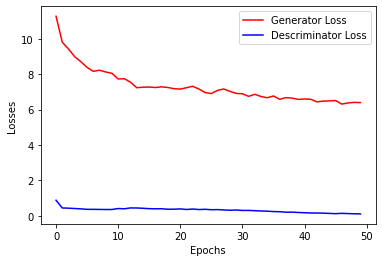

In [50]:
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.plot(gan.gen_stats.losses, 'r', label='Generator Loss')
plt.plot(gan.desc_stats.losses, 'b', label='Descriminator Loss')
plt.legend()

plt.savefig("./loss.png")


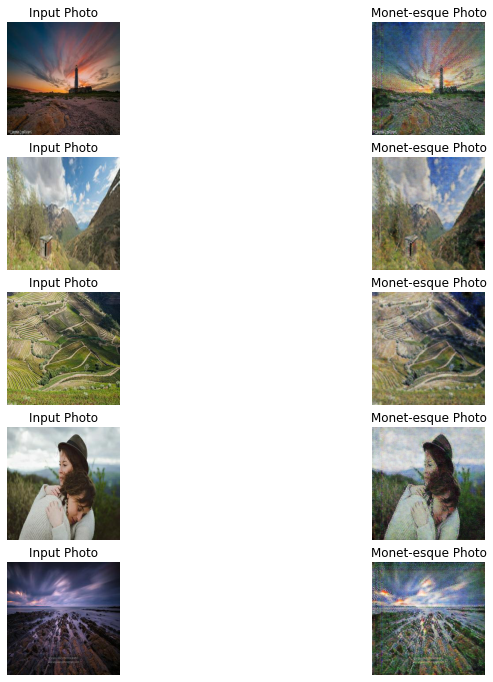

In [29]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i in range(5):
    photo_img, _ = next(iter(img_dl))
    pred_monet = gan.gen_ptm(photo_img.to(device)).cpu().detach()
    photo_img = de_normalize(photo_img)
    pred_monet = de_normalize(pred_monet)
    
    ax[i, 0].imshow(photo_img[0].permute(1, 2, 0))
    ax[i, 1].imshow(pred_monet[0].permute(1, 2, 0))
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque Photo")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    
plt.show()

# Run Generator over all images

In [30]:
class PhotoDataset(Dataset):
    def __init__(self, photo_dir, size=(256, 256), normalize=True):
        super().__init__()
        self.photo_dir = photo_dir
        self.photo_idx = dict()
        if normalize:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor()                               
            ])
        for i, fl in enumerate(os.listdir(self.photo_dir)):
            self.photo_idx[i] = fl

    def __getitem__(self, idx):
        photo_path = os.path.join(self.photo_dir, self.photo_idx[idx])
        photo_img = Image.open(photo_path)
        photo_img = self.transform(photo_img)
        return photo_img

    def __len__(self):
        return len(self.photo_idx.keys())

In [31]:
ph_ds = PhotoDataset(data_dir+'/photo_jpg/')

In [32]:
ph_dl = DataLoader(ph_ds, batch_size=1, pin_memory=True)

In [34]:
trans = transforms.ToPILImage()

In [35]:
t = tqdm(ph_dl, leave=False, total=ph_dl.__len__())
for i, photo in enumerate(t):
    with torch.no_grad():
        pred_monet = gan.gen_ptm(photo.to(device)).cpu().detach()
    pred_monet = de_normalize(pred_monet)
    img = trans(pred_monet[0]).convert("RGB")
    img.save(data_dir+"images/" + str(i+1) + ".jpg")

  0%|          | 0/7038 [00:00<?, ?it/s]